<a href="https://colab.research.google.com/github/ashp902/blind-label/blob/main/Augmentation_Suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Contribution 2: Augmentation Suite for Food Label OCR

This notebook demonstrates my contribution to the **data augmentation pipeline** used to
train the custom CNN–LSTM–CTC OCR model for food labels.

The augmentation suite implements the transformations described in the proposal:

- Rotation (±15°), small shifts & scale changes
- Perspective distortion (simulating angled shots)
- Brightness & contrast changes, gamma, CLAHE
- Blur (Gaussian, motion) and Gaussian noise
- JPEG compression artifacts
- Random occlusion / Cutout to simulate partial text

Output: visual examples and a reusable function to augment a dataset directory.


In [14]:
!pip install -q albumentations==1.4.3 opencv-python-headless


In [15]:
import cv2
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

DATA_ROOT = Path("/content/food_label_ocr_dataset")

def load_sample_image() -> np.ndarray:
    """
    Try to load a sample label crop from the dataset created in Notebook 1.
    If none exists, generate a synthetic label image with text.
    """
    candidate_dir = DATA_ROOT / "processed" / "train" / "images"
    candidate_images = list(candidate_dir.glob("*.png"))
    if candidate_images:
        print("Using existing sample image:", candidate_images[0])
        img = cv2.imread(str(candidate_images[0]), cv2.IMREAD_GRAYSCALE)
        return img

    print("No existing image found. Generating synthetic label image.")
    img = Image.new("L", (512, 256), color=255)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 24)
    except OSError:
        font = ImageFont.load_default()

    text = (
        "INGREDIENTS: Sugar, Cocoa Butter, Whole Milk Powder, Cocoa Mass,\n"
        "Emulsifier (Soy Lecithin), Natural Vanilla Flavour.\n"
        "ALLERGENS: Contains Milk and Soy. May contain Nuts.\n"
        "BEST BEFORE: 15/09/2026"
    )
    y = 10
    for line in text.split("\n"):
        draw.text((10, y), line, font=font, fill=0)
        y += 28

    return np.array(img)


In [17]:
import cv2
import numpy as np
import albumentations as A

augment = A.Compose(
    [
        # Geometric transforms
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.7),
        A.Perspective(scale=(0.02, 0.05), p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.02,
            scale_limit=0.05,
            rotate_limit=0,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5,
        ),

        # Lighting / contrast
        A.OneOf(
            [
                A.RandomBrightnessContrast(
                    brightness_limit=0.3, contrast_limit=0.3, p=1.0
                ),
                A.CLAHE(clip_limit=2.0, p=1.0),
                A.RandomGamma(gamma_limit=(80, 120), p=1.0),
            ],
            p=0.9,
        ),

        # Blur / noise
        A.OneOf(
            [
                A.GaussianBlur(blur_limit=(3, 5), p=1.0),
                A.MotionBlur(blur_limit=5, p=1.0),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            ],
            p=0.7,
        ),

        # JPEG / image compression artifacts
        A.ImageCompression(quality_lower=40, quality_upper=90, p=0.5),

        # Random occlusion (Cutout-style) using CoarseDropout
        A.CoarseDropout(
            max_holes=3,      # up to 3 holes
            min_holes=1,
            max_height=10,    # similar to max_h_size
            max_width=40,     # similar to max_w_size
            min_height=5,
            min_width=10,
            fill_value=255,   # white patches on grayscale text image
            p=0.5,
        ),
    ]
)


No existing image found. Generating synthetic label image.


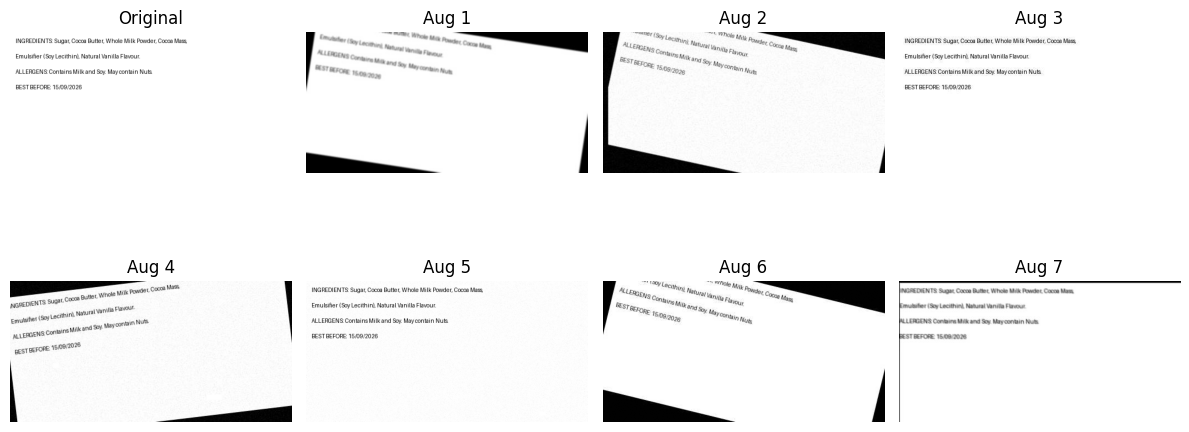

In [18]:
def apply_augmentations(img: np.ndarray, n: int = 7):
    augmented = []
    for _ in range(n):
        out = augment(image=img)["image"]
        augmented.append(out)
    return augmented

img = load_sample_image()
augmented_images = apply_augmentations(img, n=7)

plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, aug_img in enumerate(augmented_images, start=2):
    plt.subplot(2, 4, i)
    plt.imshow(aug_img, cmap="gray")
    plt.title(f"Aug {i-1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [19]:
def augment_dataset(input_dir, output_dir, copies_per_image=4):
    """
    Apply the augmentation suite to every image in input_dir and
    save augmented images to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    image_paths = list(input_dir.glob("*.png"))
    print(f"Found {len(image_paths)} images in {input_dir}")

    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        for i in range(copies_per_image):
            aug_img = augment(image=img)["image"]
            out_name = f"{img_path.stem}_aug{i+1}.png"
            out_path = output_dir / out_name
            cv2.imwrite(str(out_path), aug_img)

    print(f"Augmented images saved to: {output_dir}")

# Example: augment processed train images (if they exist)
train_images_dir = DATA_ROOT / "processed" / "train" / "images"
aug_output_dir = DATA_ROOT / "processed" / "train" / "images_aug"

augment_dataset(train_images_dir, aug_output_dir, copies_per_image=4)


Found 0 images in /content/food_label_ocr_dataset/processed/train/images
Augmented images saved to: /content/food_label_ocr_dataset/processed/train/images_aug
